In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import cm
import json
from scipy.stats import kurtosis, skew, ks_2samp
from statsmodels.tsa.stattools import acf
import pyDOE
from smt.sampling_methods import LHS
import subprocess
from analytics.trqx.turquoise_exchange import get_trades, get_orders, get_market_data
from datetime import datetime
from pykalman import KalmanFilter
import scipy.interpolate as interpolate
import scipy.stats as sc
from functools import reduce
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.weightstats import CompareMeans
import statsmodels.stats.weightstats as ws
turquoise_datetime_format = "%d-%b-%Y %H:%M:%S.%f"

In [2]:
# Functions for analysing historical and simulated stylised facts
def get_synthetic_market_data(data_path, tick_size=.02):
    df_lob_l1 = pd.read_csv('{0}/lob_l1.csv'.format(data_path)).set_index('time')
    df_lob_l1.index = pd.to_datetime(df_lob_l1.index, format=turquoise_datetime_format)

    l1B = df_lob_l1[df_lob_l1['side']  == 'B']
    l1S = df_lob_l1[df_lob_l1['side']  == 'S']
    
    mp = .5 * l1B['prc'] + .5 * l1S['prc']
    spread = l1S['prc'] - l1B['prc']
    spread = np.round(spread.fillna(method='ffill').fillna(method='bfill') / tick_size).dropna().astype(int)
    
    orders = pd.read_csv('{0}/orders.csv'.format(data_path)).set_index('time')
    orders.index = pd.to_datetime(orders.index, format=turquoise_datetime_format)
    
    b0 = l1B['prc'].shift(1)
    a0 = l1S['prc'].shift(1)
    depth_b = np.round((b0.reindex(orders.index) - orders['prc']) / tick_size)
    depth_a = np.round((orders['prc'] - a0.reindex(orders.index)) / tick_size)

    orders.loc[:,'depth'] = ((orders['side'] == 'B') * depth_b + (orders['side'] == 'S') * depth_a).values
    
    market_orders = orders[orders['OrdType'] == 'M'].copy()
    
    trades = pd.read_csv('{0}/trades.csv'.format(data_path)).set_index('time')
    trades.index = pd.to_datetime(trades.index, format=turquoise_datetime_format)
    md = {'l1B': l1B, 'l1S': l1S, 'mp': mp, 'spread': spread, 'orders': orders, 'trades': trades, 'a0': a0, 'b0': b0, 'market_orders': market_orders}
    return md

def get_synthetic_market_data_simplified(data_path, tick_size=.02):
    df_lob_l1 = pd.read_csv('{0}/lob_l1.csv'.format(data_path)).set_index('time')
    df_lob_l1.index = pd.to_datetime(df_lob_l1.index, format=turquoise_datetime_format)

    l1B = df_lob_l1[df_lob_l1['side']  == 'B']
    l1S = df_lob_l1[df_lob_l1['side']  == 'S']
    
    mp = .5 * l1B['prc'] + .5 * l1S['prc']
    
    orders = pd.read_csv('{0}/orders.csv'.format(data_path)).set_index('time')
    # orders.index = pd.to_datetime(orders.index, format=turquoise_datetime_format)
    
    md = {'mp': mp, 'orders': orders}
    return md

def get_fv_mv_value(data_path):
    fv = pd.read_csv('{0}/fundamental_value.csv'.format(data_path)).set_index('timestamp')
    fv.index = pd.to_datetime(fv.index, format=turquoise_datetime_format).floor('S')
    mv = pd.read_csv('{0}/momentum_value.csv'.format(data_path)).set_index('timestamp')
    mv.index = pd.to_datetime(mv.index, format=turquoise_datetime_format).floor('S')
    return fv.squeeze(), mv.squeeze()

def get_depth_std(orders, raw_mid, tick_size, ub=100):
    tmp = orders.copy()
    mid = raw_mid[~raw_mid.index.duplicated(keep='last')]
    tmp['tick'] = ((tmp['PRICE'] - mid) / tick_size).round()
    limit_order = tmp[tmp['EXECTYPE'] == 'Insert']
    sell = limit_order[limit_order['SIDE'] == 'Sell'].copy()
    sell = sell[(sell['tick'] < ub) & (sell['tick'] >= 0)]
    sell_ticks = sell.groupby('tick')['VISIBLEQTY'].sum()
    sell_pdf = sell_ticks / sell_ticks.sum()
    mean = np.sum(sell_pdf.index.to_numpy() * sell_pdf.values)
    var = np.sum(((sell_pdf.index.to_numpy() - mean)**2) * sell_pdf.values)
    l_std = np.sqrt(np.log(1+(var/(mean**2))))
    return l_std

# Distance Calculation
# Volatility
def sec_volatility_diff(ret1, ret2):
    return np.abs(ret1.std() - ret2.std())
# Autocorrelation diff
# For return first order acf, use small lags
def acf_diff(data1, data2, nlags):
    acf1 = acf(data1, nlags=nlags, fft=True)
    acf2 = acf(data2, nlags=nlags, fft=True)
    diff = acf1 - acf2
    return np.sum(np.abs(diff)) / (len(diff)-1)

# TODO: weights according to bootstrapped variance
def compute_distance(simulated, historical, ret1_lag=5, ret2_lag=5, bs_lag=5, mo_lag=5):
    ret_s, ret_h = simulated['ret'], historical['ret']
    vol_diff = sec_volatility_diff(ret_s, ret_h)
    cdf_ks = ks_2samp(ret_s, ret_h).statistic
    ret1_acf_diff = acf_diff(ret_s, ret_h, nlags=ret1_lag)
    ret2_acf_diff = acf_diff(ret_s**2, ret_h**2, nlags=ret2_lag)
    bs_series_s, bs_series_h = simulated['bs_series'], historical['bs_series']
    mo_series_s, mo_series_h = simulated['mo_series'], historical['mo_series']
    bs_acf_diff = acf_diff(bs_series_s, bs_series_h, nlags=bs_lag)
    mo_acf_diff = acf_diff(mo_series_s, mo_series_h, nlags=mo_lag)
    num_scaler = 5. * historical['insert']
    insert_diff = abs(historical['insert'] - simulated['insert']) / num_scaler
    return cdf_ks, ret1_acf_diff, ret2_acf_diff, bs_acf_diff, mo_acf_diff, insert_diff
def get_historical(symbol, mic, datestr, tick_size, start, end):
    cloud_path = "D:/Simudyne Limited/Data - LSE Market Data"
    lit_path = '{0}/{1}'.format(cloud_path,  'L2/data-x.londonstockexchange.com/data-x/TRQX')
    lob_path = '{0}/{1}'.format(cloud_path,  'LOB')
    md = get_market_data(lit_path, lob_path, symbol, mic, pd.to_datetime(datestr), tick_size, include_l2=True)
    l1 = md['l1']
    h_depth = l1[l1['side'] == 'S'].depth + l1[l1['side'] == 'B'].depth
    equilibrium = h_depth.median()
    b0 = l1[l1['side'] == 'B'].prc.round(2)
    a0 = l1[l1['side'] == 'S'].prc.round(2)
    raw_mid = ((a0 + b0) / 2.).dropna().loc[start:end]
    min_mid = raw_mid.resample('1min').apply(lambda i: i[-1] if len(i) > 0 else np.nan).fillna(method='ffill').dropna()
    mid = raw_mid.resample('1S').apply(lambda i: i[-1] if len(i) > 0 else np.nan).fillna(method='ffill').dropna()
    ret_h = (mid.values[1:] / mid.values[:-1] - 1) * 10000
    raw_ret_h = (raw_mid.values[1:] / raw_mid.values[:-1] - 1) * 10000
    market_orders = md['market_orders']
    mo_sign = market_orders['SIDE'].apply(lambda x: 1 if x=='Buy' else -1)
    h_orders = md['orders']
    insert_num = (h_orders['EXECTYPE'] == 'Insert').sum()
    exe_insert = h_orders['EXECTYPE'] == 'Insert'
    mo_ratio = len(market_orders) / insert_num
    cancel_delta = insert_num / (8.5*36000) * (1 - mo_ratio) / equilibrium # Using 100ms as simulation step size
    l_std = get_depth_std(h_orders, raw_mid, tick_size, ub=100)
    real_orders = h_orders.dropna().copy()
    real_orders = real_orders[(real_orders['EXECTYPE']=='Insert') | (real_orders['EXECTYPE']=='Cancel')] # whether includr 'M'
    real_orders['tmp1'] = real_orders['SIDE'].apply(lambda x: 1 if x=='Buy' else -1)
    real_orders['tmp2'] = real_orders['EXECTYPE'].apply(lambda x: -1 if x=='Cancel' else 1)
    real_orders['pressure'] = real_orders['tmp1'] * real_orders['tmp2']
    real_p_series = real_orders['pressure']
    historical = {'ret': ret_h, 'bs_series': real_p_series, 'mo_series': mo_sign, 'raw_ret': raw_ret_h, 'insert': insert_num}
    tick_prc = ((a0 + b0) / 2.).dropna()
    return historical, tick_prc, mo_ratio, cancel_delta, l_std, exe_insert
def get_simulated(data_path, tick_size, start, end):
    md = get_synthetic_market_data_simplified(data_path, tick_size=tick_size)
    raw_mp, orders = md['mp'], md['orders']
    raw_mp = raw_mp.dropna().loc[start:end]
    # min_mp = raw_mp.resample('1min').last().fillna(method='ffill').dropna()
    mp = raw_mp.resample('1S').last().fillna(method='ffill').dropna()#.last .reindex
    ret_s = (mp.values[1:] / mp.values[:-1] - 1) * 10000
    raw_ret_s = (raw_mp.values[1:] / raw_mp.values[:-1] - 1) * 10000
    # Orders autocorrelation analysis
    L_num = (orders['OrdType'] == 'L').sum()
    orders_data = orders.copy()
    orders_data['tmp1'] = orders_data['side'].apply(lambda x: 1 if x=='B' else -1)
    orders_data['tmp2'] = orders_data['OrdType'].apply(lambda x: -1 if x=='C' else 1)
    orders_data['pressure'] = orders_data['tmp1'] * orders_data['tmp2']
    p_series = orders_data[(orders_data['pressure']!=0) & (orders_data['OrdType']!='M')]['pressure']
    # market order autocorrelation
    mo_series_s = orders_data[orders_data['OrdType'] == 'M']['pressure']
    simulated = {'ret': ret_s, 'bs_series': p_series, 'mo_series': mo_series_s, 'raw_ret': raw_ret_s, 'insert': L_num}
    return simulated

In [3]:
# Get fundamental value from Kalman smoothing and interpolation
def Kalman1D(observations,damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state
def get_interpolated_v(tick_prc, damping_factor=20):
    tick_mid = tick_prc.dropna()
    tmp = tick_mid.resample('1min').last().ffill().dropna()
    P = tmp.values
    Ve = Kalman1D(P, damping=damping_factor)[:,0]
    x = np.concatenate(([0], tick_mid.resample('1min').count().apply(lambda x: x if x!=0 else 1).cumsum().values))
    y = np.concatenate((Ve[:1], Ve))
    f = interpolate.interp1d(x, y, kind='cubic')
    newx = np.arange(0, len(tick_mid))
    inter_mid = f(newx)
    V_series = pd.Series(inter_mid, index=tick_mid.index)
    V_series = V_series.resample('100ms').last().ffill().bfill()
    return V_series, inter_mid
def plot_fundamental(inter_mid, tick_prc):
    fg, ax = plt.subplots(1,1,figsize=(10,2))
    pd.Series(inter_mid).plot(ax=ax, label='Interpolated from minute value', color='k')
    pd.Series(tick_prc.values).plot(ax=ax, label='tick mid price', style=':r')
    ax.legend(loc='best')
    ax.grid(True)
    ax.set_ylim((inter_mid.min()*0.99, inter_mid.max()*1.01))
    ax.set_title('Market Prices-%s-interpolated from minute value'%(datestr))
    plt.show()

In [4]:
# Auxiliary functions
def update_sim_params(sim_params, prc, tick_size, datestr, n_runs=3):
    sim_params['closing_bid_prc'] = (prc // tick_size - 1) * tick_size
    sim_params['closing_ask_prc'] = (prc // tick_size + 1) * tick_size
    sim_params['tick_size'] = tick_size
    sim_params['date'] = datetime.strftime(pd.to_datetime(datestr), "%Y-%m-%d")
    sim_params['n_runs'] = n_runs

def save_model_params(model_params, save_path):
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(model_params, f, ensure_ascii=False, indent=2)
        f.close()

def save_sim_params(sim_params, save_path):
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(sim_params, f, ensure_ascii=False, indent=2)
        f.close()

def run_simulation():
    cmd = "D:/projects/chiarella-abm/simulator/cmake-build-release/ZeroIntelligenceMarket.exe MultipleRun True"
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, cwd=r'D:/projects/chiarella-abm/simulator/cmake-build-release/')
    output = process.wait()
    return output

In [5]:
# GSL-div analysis
def get_symbolised_ts(ts, b, L, min_per=1, max_per=99, state_space=None):
    # if no state space is defined we generate our own based on
    # either the standard percentiles or those given by the user
    cuts = []
    if not state_space:
        for x in ts:
            min_p = np.percentile(x, min_per)
            max_p = np.percentile(x, max_per)
            cuts.append(np.linspace(min_p, max_p, b+1))
    else:
        cuts = np.linspace(state_space[0], state_space[1], b+1)
    # now we map the time series to the bins in the symbol space
    symbolised_ts = np.array([np.clip(np.digitize(t, cut, right=True), 1, b) for t, cut in zip(ts,cuts)])
    # to be able to deal with "words" or combination of symbols it is easier
    # to deal with them as strings in pandas dfs
    # TODO: Maybe better way of doing this
    sym_str = pd.DataFrame(symbolised_ts).astype(str)
    # collect all symbol dataframes based on block size given
    all_dfs = []
    all_dfs.append(sym_str)
    tmp = sym_str.values
    for l in range(1, L):
        tmp = tmp[:, :-1] + sym_str.values[:, l:]
        all_dfs.append(pd.DataFrame(tmp))
    return all_dfs


def get_weights(weight_type, L):
    if weight_type == 'uniform':
        w = np.array([1. / L] * L)
    elif weight_type == 'add-progressive':
        w = np.array([2. / (L * (L + 1))]*L).cumsum()
    return w


def gsl_div(original, model, weights='add-progressive', b=5, L=6, min_per=1, max_per=99, state_space=None):
    all_ts = np.concatenate([original, model])
    # determine the time series length
    T = original.shape[1]
    if T < L:
        raise ValueError('Word length cant be longer than timeseries')
    # symbolise time-series
    sym_ts = get_symbolised_ts(all_ts, b=b, L=L, min_per=min_per,
                               max_per=max_per, state_space=state_space)
    raw_divergence = []
    correction = []
    # run over all word sizes
    for n, ts in enumerate(sym_ts):
        # get frequency distributions for original and replicates
        # could do it by applying a pd.value_counts to every column but this
        # way you get a 10x speed up
        fs = pd.DataFrame((ts.stack().reset_index()
                           .groupby([0, "level_0"]).count() /
                           len(ts.T)).unstack().values.astype(float))

        # replace NaN with 0 so that log does not complain later
        fs = fs.replace(np.nan, 0)
        # determine the size of vocabulary for the right base in the log
        base = b**(n+1)
        # calculate the distances between the different time-series
        # give a particluar word size
        M = (fs.iloc[:, 1:].values +
             np.expand_dims(fs.iloc[:, 0].values, 1)) / 2.
        temp = (2 * sc.entropy(M, base=base) -
                sc.entropy(fs.values[:, 1:], base=base))
        raw_divergence.append(reduce(np.add, temp) /
                              float((len(fs.columns) - 1)))
        cardinality_of_m = fs.apply(lambda x: reduce(np.logical_or, x),
                                    axis=1).sum()
        # if there is only one replicate this has to be handled differently
        if len(fs.columns) == 2:
            cardinality_of_reps = fs.iloc[:, 1].apply(lambda x: x != 0).sum()
        else:
            cardinality_of_reps = fs.iloc[:, 1:].apply(
                lambda x: reduce(np.logical_or, x), axis=1).sum()
        # calculate correction based on formula 9 line 2 in paper
        correction.append(2*((cardinality_of_m - 1) / (4. * T)) -
                          ((cardinality_of_reps - 1) / (2. * T)))

    w = get_weights(weight_type=weights, L=L)
    weighted_res = (w * np.array(raw_divergence)).sum(axis=0)
    weighted_correction = (w * np.array(correction)).sum()

    return weighted_res + weighted_correction

def ret_gsl_div(ret_h, ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000):
    length = min(len(ret_h), len(ret_s))
    res_list = []
    for i in range(length//unit):
        h_ts = ret_h[(i*unit):((i+1)*unit)].reshape(1,-1)
        s_ts = ret_s[(i*unit):((i+1)*unit)].reshape(1,-1)
        res_list.append(gsl_div(h_ts, s_ts, 'add-progressive',b=b, L=L, min_per=min_per, max_per=max_per))
    # print(res_list)
    return np.mean(res_list), res_list

In [6]:
# function to optimize; maps ABM model parameters to model-real distances
def func_opt(n_sigma, f_kappa, m_beta, s_beta):
    tmp = {}
    tmp['n_sigma'], tmp['f_kappa'], tmp['m_beta'], tmp['s_beta'] = n_sigma, f_kappa, m_beta, s_beta
    update_model_params(model_params, tmp)
    save_model_params(model_params, save_path='MultipleRun/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    names = [x for x in os.listdir(res_directory) if 'run_' in x]
    tmp_dist = []
    for n_ in names:
        data_path = res_directory + n_
        simulated = get_simulated(data_path, tick_size, start, end)
        dist = compute_distance(simulated, historical, ret1_lag=5, ret2_lag=5, bs_lag=5, mo_lag=5)
        tmp_dist.append(dist)

    intermediate = np.array(tmp_dist).mean(axis=0) + np.array(tmp_dist).std(axis=0)
    return -1. * intermediate.sum()

def func_opt_mt1(n_sigma, f_kappa, m_beta):
    tmp = {}
    tmp['n_sigma'], tmp['f_kappa'], tmp['m_beta'] = n_sigma, f_kappa, m_beta
    update_model_params(model_params, tmp)
    save_model_params(model_params, save_path='MultipleRun/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    names = [x for x in os.listdir(res_directory) if 'run_' in x]
    tmp_dist = []
    for n_ in names:
        data_path = res_directory + n_
        simulated = get_simulated(data_path, tick_size, start, end)
        dist = compute_distance(simulated, historical, ret1_lag=5, ret2_lag=5, bs_lag=5, mo_lag=5)
        tmp_dist.append(dist)

    intermediate = np.array(tmp_dist).mean(axis=0) + np.array(tmp_dist).std(axis=0)
    return -1. * intermediate.sum()


In [7]:
def block_bootstrap_ind(length, n_block):
    block_size = length // n_block
    samples = np.random.choice(n_block, size=n_block, replace=True)
    new_ind = np.concatenate([np.arange(i*block_size, (i+1)*block_size) for i in samples])
    return new_ind

def get_datestr_list(trades_directory, begin_date='20210101', end_date='20210131'):
    # input the trades_directory, extract the trading date and put in a list of string
    total_list = os.listdir(trades_directory)
    try:
        date_list = [x[-22:-14] for x in total_list if x[-22:-14] >= begin_date and x[-22:-14] <= end_date]
    except:
        raise Exception("Invalid files in given trades_directory")
    return date_list

In [8]:
# Fix market order ratio to 0.1(then test when change mo_ratio of HF_MT changes to 0.01)
# sbeta_mo_ratio = 0.1

In [9]:
sim_params = {
  "reference_prc": 125.24,
  "closing_bid_prc": 128.22,
  "closing_ask_prc": 128.26,
  "tick_size": 0.02,
  "l2_depth": 10,
  "symbol": "ZIl",
  "tick_format": "LSE",
  "date": "2021-01-28",
  "date_format": "%d-%b-%Y %H:%M:%S",
  "n_runs": 3,
  "n_zi_traders": 30,
  "n_ft_traders": 30,
  "n_mt_traders": 30,
  "n_st_traders": 30,
  "n_mins": 510,
  "step_size": 100000,
  "n_threads": 6,
  "verbose": 2,
  "seed": 1234
}

In [13]:
symbol = 'BARCl'
mic = 'XLON'
tick_size = .02
res_directory = 'MultipleRun/Results/'

saved_params_file = 'model_params/2MT/'+symbol+'.json'
with open(saved_params_file, 'r', encoding='utf-8') as f:
    params_record = json.load(f)
    f.close()

begin_date, end_date = '20210101', '20210130'
cloud_path = "D:/Simudyne Limited/Data - LSE Market Data"
trades_path = '{0}/{1}/{2}/'.format(cloud_path, 'L2/data-x.londonstockexchange.com/data-x/TRQX/LitTrades', symbol)
date_list = get_datestr_list(trades_path, begin_date=begin_date, end_date=end_date)

20210104


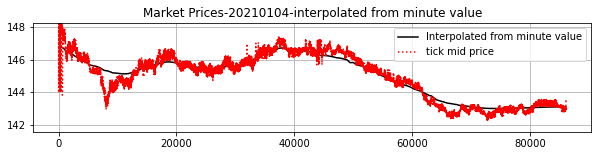

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (1.91136391035395, 0.05770189777255032, 164.0)
t Test random-real div and bootstrap-real:  (10.224413501046582, 2.572707414252313e-19, 165.0)
z Test model-real div and bootstrap-real:  (1.9121744764240902, 0.055853818712744426)
z Test random-real div and bootstrap-real:  (10.212700364332411, 1.739549666746535e-24)
20210105


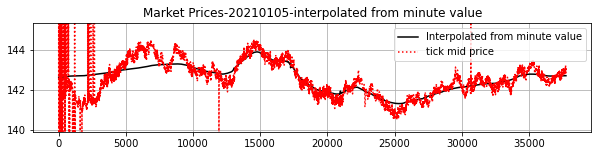

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (0.4616186831407552, 0.6457660294075667, 71.0)
t Test random-real div and bootstrap-real:  (6.397775263388059, 1.4632071603903184e-08, 71.0)
z Test model-real div and bootstrap-real:  (0.4620487504324975, 0.644046360976366)
z Test random-real div and bootstrap-real:  (6.3942571033118245, 1.6132977859143524e-10)
20210106


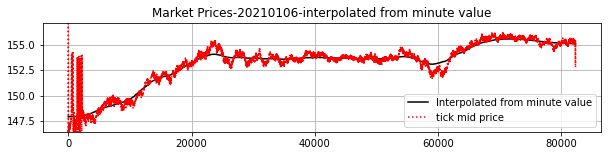

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (0.5227680873240164, 0.6018679316308986, 158.0)
t Test random-real div and bootstrap-real:  (12.297382104847578, 8.252908268155946e-25, 158.0)
z Test model-real div and bootstrap-real:  (0.5229620123194506, 0.601000688963798)
z Test random-real div and bootstrap-real:  (12.288843240047624, 1.039833177298045e-34)
20210107


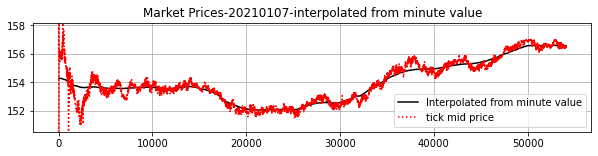

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (0.7134273079735018, 0.477194761345512, 103.0)
t Test random-real div and bootstrap-real:  (9.46762941033404, 1.1300575109863263e-15, 103.0)
z Test model-real div and bootstrap-real:  (0.7137623285802117, 0.4753741577048798)
z Test random-real div and bootstrap-real:  (9.456177004630117, 3.194079840913043e-21)
20210108


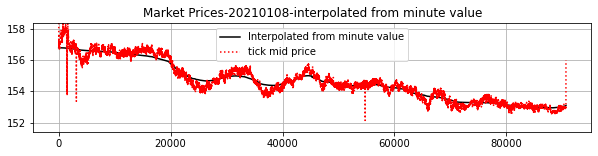

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (1.9201164879687562, 0.05655775861947348, 166.0)
t Test random-real div and bootstrap-real:  (10.954449319624409, 1.3428293759201706e-21, 175.0)
z Test model-real div and bootstrap-real:  (1.9084308308961087, 0.05633555518952319)
z Test random-real div and bootstrap-real:  (10.94831133987938, 6.769789403124615e-28)
20210111


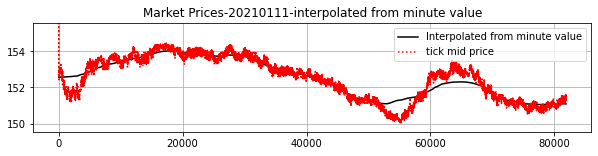

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (2.119401072838414, 0.0356294017105093, 157.0)
t Test random-real div and bootstrap-real:  (10.395627401817265, 1.3762015793314428e-19, 157.0)
z Test model-real div and bootstrap-real:  (2.1214679950721136, 0.03388243850640776)
z Test random-real div and bootstrap-real:  (10.391973330707815, 2.697142081527168e-25)
20210112


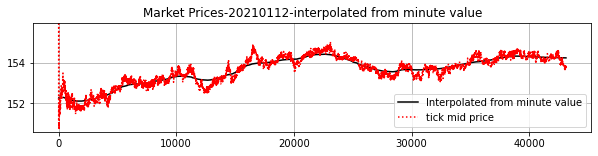

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (0.1875333529550744, 0.8517233040546228, 79.0)
t Test random-real div and bootstrap-real:  (6.461944000725151, 7.82518861437502e-09, 79.0)
z Test model-real div and bootstrap-real:  (0.18881903362688923, 0.8502346535009963)
z Test random-real div and bootstrap-real:  (6.465247889722091, 1.0113288275770985e-10)
20210113


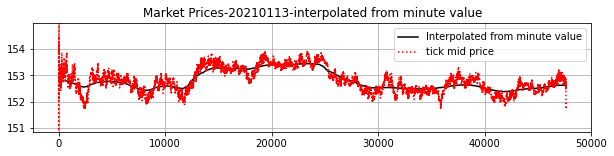

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (0.7507862410585174, 0.4547398370611605, 90.0)
t Test random-real div and bootstrap-real:  (9.19116628657587, 1.3767385130805989e-14, 90.0)
z Test model-real div and bootstrap-real:  (0.7504174938957769, 0.4530032980439529)
z Test random-real div and bootstrap-real:  (9.158294295914086, 5.2724061602532805e-20)
20210114


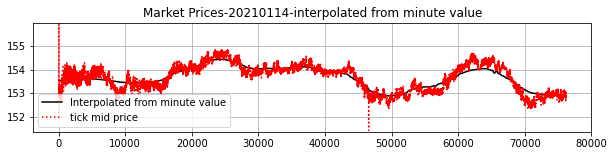

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (2.7794851106585083, 0.006161510680151877, 146.0)
t Test random-real div and bootstrap-real:  (9.838005102457963, 7.776644711444961e-18, 146.0)
z Test model-real div and bootstrap-real:  (2.7874099446102276, 0.005313121937591076)
z Test random-real div and bootstrap-real:  (9.823080994225084, 8.956352954986875e-23)
20210115


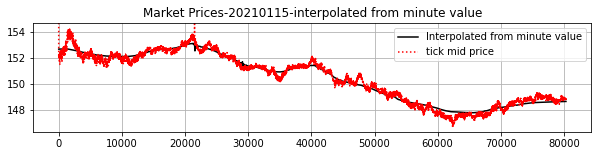

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (3.0548647399955073, 0.0026597207212310982, 152.0)
t Test random-real div and bootstrap-real:  (12.379032308149254, 7.972322961650579e-25, 153.0)
z Test model-real div and bootstrap-real:  (3.065448376922703, 0.0021734389407064426)
z Test random-real div and bootstrap-real:  (12.361277368751596, 4.233750880365785e-35)
20210118


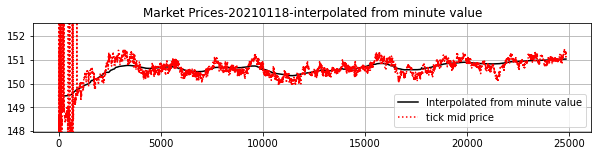

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (1.6151019557477366, 0.11312784743737547, 46.0)
t Test random-real div and bootstrap-real:  (5.420833360269599, 2.1154288423267594e-06, 46.0)
z Test model-real div and bootstrap-real:  (1.6151019557477364, 0.10628861751092122)
z Test random-real div and bootstrap-real:  (5.420833360269599, 5.932183866115928e-08)
20210119


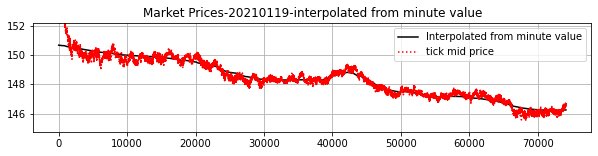

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (1.5299214778191639, 0.12827658540090536, 141.0)
t Test random-real div and bootstrap-real:  (10.140156633156007, 1.3533273871688324e-18, 145.0)
z Test model-real div and bootstrap-real:  (1.5257580159495925, 0.1270701400777231)
z Test random-real div and bootstrap-real:  (10.13767986467175, 3.7592182812988744e-24)
20210120


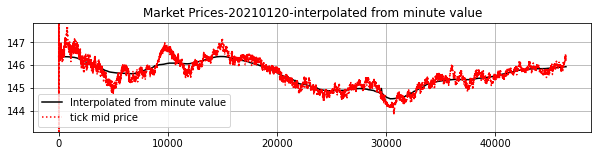

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (0.5839226519033244, 0.5607494100677228, 89.0)
t Test random-real div and bootstrap-real:  (6.656369129396375, 2.228226227485832e-09, 89.0)
z Test model-real div and bootstrap-real:  (0.5845971582047037, 0.5588186189642583)
z Test random-real div and bootstrap-real:  (6.6518918649449885, 2.893492679373049e-11)
20210121


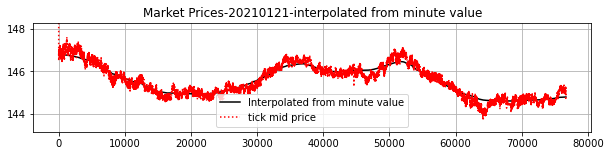

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (1.6014890706721152, 0.11141543272859723, 147.0)
t Test random-real div and bootstrap-real:  (8.073315139556637, 2.2531076870125606e-13, 147.0)
z Test model-real div and bootstrap-real:  (1.6056554712993865, 0.10834963013540018)
z Test random-real div and bootstrap-real:  (8.060152616470706, 7.619925524466088e-16)
20210122


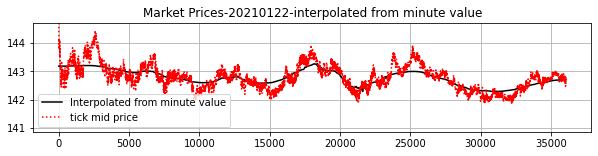

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (3.2050157519010636, 0.0020818799367283624, 66.0)
t Test random-real div and bootstrap-real:  (7.841243344608571, 5.093838565002293e-11, 66.0)
z Test model-real div and bootstrap-real:  (3.2414006242543754, 0.001189438965223543)
z Test random-real div and bootstrap-real:  (7.8033800802645965, 6.0270676658582846e-15)
20210125


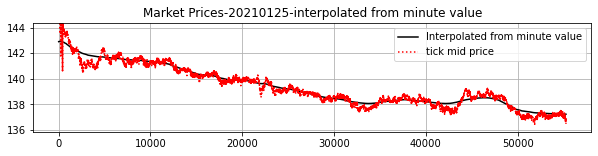

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (1.6789079641286981, 0.09617219796676502, 104.0)
t Test random-real div and bootstrap-real:  (10.257787308113318, 1.785658482484199e-17, 104.0)
z Test model-real div and bootstrap-real:  (1.6853240012195505, 0.09192607750730389)
z Test random-real div and bootstrap-real:  (10.215826268656947, 1.6843791317446537e-24)
20210126


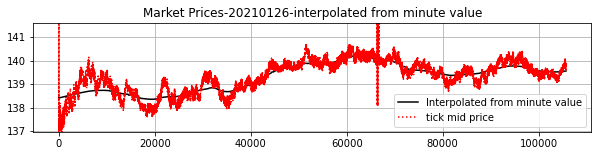

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (2.222535619225266, 0.027492485687206355, 180.0)
t Test random-real div and bootstrap-real:  (9.607007557538946, 2.6366121447455593e-18, 207.0)
z Test model-real div and bootstrap-real:  (2.1681657218692894, 0.03014607984454732)
z Test random-real div and bootstrap-real:  (9.606409501571735, 7.512296107757491e-22)
20210127


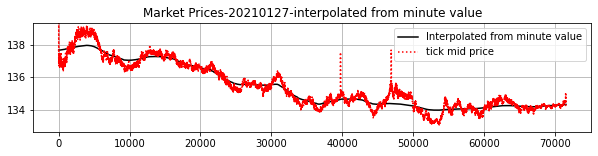

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (2.0804177562783956, 0.03932305777563418, 139.0)
t Test random-real div and bootstrap-real:  (9.176222443046504, 5.511384340327318e-16, 139.0)
z Test model-real div and bootstrap-real:  (2.082653413411596, 0.037282826741135165)
z Test random-real div and bootstrap-real:  (9.167812120532, 4.827164186439099e-20)
20210128


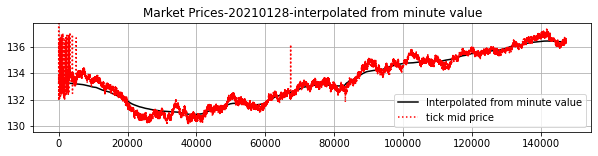

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (2.604764908147659, 0.009765307293072041, 241.0)
t Test random-real div and bootstrap-real:  (11.875907145012922, 1.0343984339198786e-26, 286.0)
z Test model-real div and bootstrap-real:  (2.517471958304665, 0.011820037808547472)
z Test random-real div and bootstrap-real:  (11.87077361619524, 1.6790772019643457e-32)
20210129


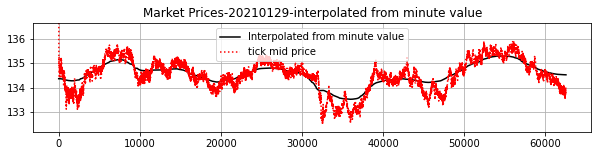

--------------
raw_ret
raw_ret
t Test model-real div and bootstrap-real:  (3.4186776966484462, 0.0008601866348219417, 120.0)
t Test random-real div and bootstrap-real:  (10.949425809657841, 9.093256968827024e-20, 120.0)
z Test model-real div and bootstrap-real:  (3.418677696648446, 0.0006292621478677205)
z Test random-real div and bootstrap-real:  (10.949425809657843, 6.68701535148048e-28)


In [14]:
res = {}
for datestr in date_list:
    model_params = params_record[datestr]
    start = pd.to_datetime(datestr + ' 08:02:00')
    end = pd.to_datetime(datestr + ' 16:29:00')
    print(datestr)
    historical, tick_prc, mo_ratio, cancel_delta, l_std, exe_insert = get_historical(symbol, mic, datestr, tick_size, start, end)
    # Get fundamental value
    V_series, inter_mid = get_interpolated_v(tick_prc, damping_factor=20)
    plot_fundamental(inter_mid, tick_prc)
    V_series.to_csv('MultipleRun/source_fv.csv', index=False, header=False)
    # Update sim_params
    update_sim_params(sim_params, V_series.values[0], tick_size, datestr, n_runs=3)
    save_sim_params(sim_params, save_path='MultipleRun/sim_params.json')
    save_model_params(model_params, save_path='MultipleRun/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    print('--------------')
    # Historical
    ret_h = historical['ret']
    raw_ret_h = historical['raw_ret']
    bs_h = historical['bs_series'].values
    mo_h = historical['mo_series'].values
    # Simulated
    model_div_dict = {'ret': [], 'raw_ret': [], 'bs': [], 'mo': []}
    names = [x for x in os.listdir(res_directory) if 'run_' in x]
    data_path = res_directory + names[0]
    simulated = get_simulated(data_path, tick_size, start, end)
    # ret_s = simulated['ret']
    raw_ret_s = simulated['raw_ret']
    # bs_s = simulated['bs_series'].values
    # mo_s = simulated['mo_series'].values
    # print('ret')
    # model_div_dict['ret'].append(ret_gsl_div(ret_h, ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    print('raw_ret')
    model_div_dict['raw_ret'].append(ret_gsl_div(raw_ret_h, raw_ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    # print('bs')
    # model_div_dict['bs'].append(ret_gsl_div(bs_h, bs_s, b=2, L=10, min_per=0, max_per=100, unit=1000))
    # print('mo')
    # model_div_dict['mo'].append(ret_gsl_div(mo_h, mo_s, b=2, L=10, min_per=0, max_per=100, unit=1000))
    
    # Bootstrap
    n_block = 3060
    bootstrap_div_dict = {'ret': [], 'raw_ret': [], 'bs': [], 'mo': []}
    ret_ind = block_bootstrap_ind(len(historical['ret']), n_block)
    raw_ret_ind = block_bootstrap_ind(len(historical['raw_ret']), n_block)
    bs_ind = block_bootstrap_ind(len(historical['bs_series']), n_block)
    mo_ind = block_bootstrap_ind(len(historical['mo_series']), n_block//2)
    insert_ind = block_bootstrap_ind(len(exe_insert), n_block//2)

    bootstrap = {'ret': historical['ret'][ret_ind], 'bs_series': historical['bs_series'].values[bs_ind], 
                 'mo_series': historical['mo_series'].values[mo_ind], 'insert': exe_insert.values[insert_ind].sum(), 
                 'raw_ret': historical['raw_ret'][raw_ret_ind]}
    

    # ret_s = bootstrap['ret']
    raw_ret_s = bootstrap['raw_ret']
    # bs_s = bootstrap['bs_series']
    # mo_s = bootstrap['mo_series']
    # print('ret')
    # bootstrap_div_dict['ret'].append(ret_gsl_div(ret_h, ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    print('raw_ret')
    bootstrap_div_dict['raw_ret'].append(ret_gsl_div(raw_ret_h, raw_ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    # print('bs')
    # bootstrap_div_dict['bs'].append(ret_gsl_div(bs_h, bs_s, b=2, L=10, min_per=0, max_per=100, unit=1000))
    # print('mo')
    # bootstrap_div_dict['mo'].append(ret_gsl_div(mo_h, mo_s, b=2, L=10, min_per=0, max_per=100, unit=1000))
    
    # Random sample
    # normal_ts = np.random.normal(ret_h.mean(), ret_h.std(), len(ret_h))
    # random_div = ret_gsl_div(ret_h, normal_ts)
    normal_ts = np.random.normal(raw_ret_h.mean(), raw_ret_h.std(), len(raw_ret_h))
    random_div = ret_gsl_div(raw_ret_h, normal_ts)
    
    # Statistical test
    # a = model_div_dict['ret'][0][1]
    # b = bootstrap_div_dict['ret'][0][1]
    a = model_div_dict['raw_ret'][0][1]
    b = bootstrap_div_dict['raw_ret'][0][1]
    c = random_div[1]
    print("t Test model-real div and bootstrap-real: ", ttest_ind(a, b))
    print("t Test random-real div and bootstrap-real: ", ttest_ind(c, b))
    res[datestr] = [ttest_ind(a, b)[1], ttest_ind(c, b)[1]]
    col1 = ws.DescrStatsW(a)
    col2 = ws.DescrStatsW(b)
    col3 = ws.DescrStatsW(c)
    cm_obj = CompareMeans(col1, col2)
    print("z Test model-real div and bootstrap-real: ", cm_obj.ztest_ind(usevar='unequal'))
    cm_obj = CompareMeans(col3, col2)
    print("z Test random-real div and bootstrap-real: ", cm_obj.ztest_ind(usevar='unequal'))

In [15]:
print('                 P-value                P-value')
print('date,      simulated GSL-div,      random GSL-div')
for d, values in res.items():
    print('%s,        %.6f,             %.6f'%(d, values[0], values[1]))

                 P-value                P-value
date,      simulated GSL-div,      random GSL-div
20210104,        0.057702,             0.000000
20210105,        0.645766,             0.000000
20210106,        0.601868,             0.000000
20210107,        0.477195,             0.000000
20210108,        0.056558,             0.000000
20210111,        0.035629,             0.000000
20210112,        0.851723,             0.000000
20210113,        0.454740,             0.000000
20210114,        0.006162,             0.000000
20210115,        0.002660,             0.000000
20210118,        0.113128,             0.000002
20210119,        0.128277,             0.000000
20210120,        0.560749,             0.000000
20210121,        0.111415,             0.000000
20210122,        0.002082,             0.000000
20210125,        0.096172,             0.000000
20210126,        0.027492,             0.000000
20210127,        0.039323,             0.000000
20210128,        0.009765,            

## Bootstrap distance

In [31]:
n_block = 3060
length = len(exe_insert)
new_ind = block_bootstrap_ind(length, n_block)
exe_insert.values[new_ind].sum()

90659

In [96]:
np.random.seed(1234)
dist_list = []
for _ in range(100):
    ret_ind = block_bootstrap_ind(len(historical['ret']), n_block)
    bs_ind = block_bootstrap_ind(len(historical['bs_series']), n_block)
    mo_ind = block_bootstrap_ind(len(historical['mo_series']), n_block//2)
    insert_ind = block_bootstrap_ind(len(exe_insert), n_block//2)

    tmp = {'ret': historical['ret'][ret_ind], 'bs_series': historical['bs_series'].values[bs_ind], 
           'mo_series': historical['mo_series'].values[mo_ind], 'insert': exe_insert.values[insert_ind].sum()}
    dist = compute_distance(tmp, historical)
    print(dist, np.sum(dist))
    dist_list.append(np.sum(dist))

(0.009310775288244214, 0.0073384674032059925, 0.03994070136918604, 0.004216105360656185, 0.08044188710120027, 0.0018050976483345565) 0.14305303417082726
(0.00817179798879189, 0.012503760403514311, 0.04502554770215258, 0.003587079124937183, 0.0847808842455467, 0.0012377186545012432) 0.15530678811944387
(0.006937047453165812, 0.013291765651637883, 0.03354177507507279, 0.0022153312744307447, 0.085609332994974, 0.0013187727964774308) 0.14291402524575866
(0.008441799659717517, 0.014519514002982903, 0.043157991570128215, 0.00333770908195584, 0.08080181361410646, 0.0012464812644446149) 0.15150530919333557
(0.00938529370104968, 0.010285137689022643, 0.032794831053066, 0.0018281202074326736, 0.07431434634030253, 0.0015728884848352082) 0.13018061747570875
(0.008139963501292757, 0.01580935044231265, 0.03745247250282243, 0.0030552768124207396, 0.08559148766063815, 0.0012596251793596722) 0.1513081760988464
(0.007632199307455151, 0.012541248546269904, 0.05869523062887193, 0.004084906230232567, 0.086

(0.004846854139317763, 0.008467521682676234, 0.04337116817039356, 0.0018930991507913886, 0.0900524829103883, 0.0014239241157978904) 0.15005505016936513
(0.004879045539778096, 0.016144974568405728, 0.03228503294225343, 0.003597344283222256, 0.08835591213179789, 0.0011435205976099982) 0.1464058300630674
(0.010566097857225953, 0.013820863400292755, 0.034617427133631494, 0.0024529835784774154, 0.07712178245326787, 0.0014786904279439632) 0.14005784485083944
(0.004856751013435842, 0.015924055878716297, 0.03672278883684378, 0.0036937569213319347, 0.06813618343710542, 0.00164956132183971) 0.130983097409273
(0.005065258610417733, 0.013915536542705382, 0.03960046494648402, 0.0030433586230466333, 0.09311262952922787, 0.001191714952298542) 0.15592896320418015
(0.006448006268680778, 0.01761152169304407, 0.04248758673988083, 0.0029203772716791788, 0.08583078694016397, 0.0010953262429214542) 0.15639360515637027
(0.008768192384823847, 0.009428737920867684, 0.025100940358273715, 0.005605417145991625, 0

# Modle Validation - GSL-div

In [68]:
ret_h = historical['ret']
raw_ret_h = historical['raw_ret']
bs_h = historical['bs_series'].values
mo_h = historical['mo_series'].values

In [69]:
names = [x for x in os.listdir(res_directory) if 'run_' in x]
tmp_dist = []
div_dict = {'ret': [], 'raw_ret': [], 'bs': [], 'mo': []}
for n_ in names:
    print(n_)
    data_path = res_directory + n_
    simulated = get_simulated(data_path, tick_size, start, end)
    ret_s = simulated['ret']
    raw_ret_s = simulated['raw_ret']
    bs_s = simulated['bs_series'].values
    mo_s = simulated['mo_series'].values
    # print('ret')
    # div_dict['ret'].append(ret_gsl_div(ret_h, ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    print('raw_ret')
    div_dict['raw_ret'].append(ret_gsl_div(raw_ret_h, raw_ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    # print('bs')
    # div_dict['bs'].append(ret_gsl_div(bs_h, bs_s, b=2, L=10, min_per=0, max_per=100, unit=1000))
    # print('mo')
    # div_dict['mo'].append(ret_gsl_div(mo_h, mo_s, b=2, L=10, min_per=0, max_per=100, unit=1000))

    dist = compute_distance(simulated, historical, ret1_lag=5, ret2_lag=5, bs_lag=5, mo_lag=5)
    tmp_dist.append(dist)

intermediate = np.array(tmp_dist).mean(axis=0) + np.array(tmp_dist).std(axis=0)

print('distance: %.6f'%(intermediate.sum()))
# for key in div_dict.keys():
#     print('GSL-div in %7s: mean: %.6f, std: %.8f'%(key, np.mean(div_dict[key]), np.std(div_dict[key])))
# print('-----------------------------')

run_00000
raw_ret
run_00001
raw_ret
run_00002
raw_ret
distance: 0.364744


In [70]:
model_div_dict = div_dict

## Compare with Bootstrap approximation of data generation process

In [71]:
np.random.seed(1234)
dist_list = []
div_dict = {'ret': [], 'raw_ret': [], 'bs': [], 'mo': []}
for _ in range(1):
    ret_ind = block_bootstrap_ind(len(historical['ret']), n_block)
    raw_ret_ind = block_bootstrap_ind(len(historical['raw_ret']), n_block)
    bs_ind = block_bootstrap_ind(len(historical['bs_series']), n_block)
    mo_ind = block_bootstrap_ind(len(historical['mo_series']), n_block//2)
    insert_ind = block_bootstrap_ind(len(exe_insert), n_block//2)

    bootstrap = {'ret': historical['ret'][ret_ind], 'bs_series': historical['bs_series'].values[bs_ind], 
                 'mo_series': historical['mo_series'].values[mo_ind], 'insert': exe_insert.values[insert_ind].sum(), 
                 'raw_ret': historical['raw_ret'][raw_ret_ind]}
    

    ret_s = bootstrap['ret']
    raw_ret_s = bootstrap['raw_ret']
    bs_s = bootstrap['bs_series']
    mo_s = bootstrap['mo_series']
    # print('ret')
    # div_dict['ret'].append(ret_gsl_div(ret_h, ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    print('raw_ret')
    div_dict['raw_ret'].append(ret_gsl_div(raw_ret_h, raw_ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    # print('bs')
    # div_dict['bs'].append(ret_gsl_div(bs_h, bs_s, b=2, L=10, min_per=0, max_per=100, unit=1000))
    # print('mo')
    # div_dict['mo'].append(ret_gsl_div(mo_h, mo_s, b=2, L=10, min_per=0, max_per=100, unit=1000))

    dist = compute_distance(bootstrap, historical, ret1_lag=5, ret2_lag=5, bs_lag=5, mo_lag=5)
    print(dist, np.sum(dist))
    dist_list.append(np.sum(dist))
    print(div_dict)

print('distance: mean %.6f; std %.6f'%(np.mean(dist_list), np.std(dist_list)))
# for key in div_dict.keys():
#     print('GSL-div in %7s: mean: %.6f, std: %.8f'%(key, np.mean(div_dict[key]), np.std(div_dict[key])))
# print('-----------------------------')

raw_ret
(0.009310775288244214, 0.0073384674032059925, 0.03994070136918604, 0.0025944702227150645, 0.08999082195196347, 0.0016167015345520664) 0.15079193776986682
{'ret': [], 'raw_ret': [(0.4969723559686259, [0.6492930985601975, 0.5620954069161606, 0.5957118043063822, 0.6948317950368896, 0.34188724381865465, 0.5074285286044296, 0.421520655707572, 0.42228514043252074, 0.6856085391271338, 0.5775312716069959, 0.559536480391639, 0.6180823138525946, 0.4890889146796703, 0.4937958208038973, 0.47305806511904724, 0.43808471714590375, 0.5794786678170272, 0.6655967578983177, 0.5431725243516756, 0.44879175404891114, 0.635764804193759, 0.6120829357123876, 0.6139675801813473, 0.49599377247911136, 0.45530213326368446, 0.6995463907920914, 0.20080802148969615, 0.45020040331214656, 0.5327914609036687, 0.5868678195538037, 0.5579106958616857, 0.5099655334691451, 0.46420127786857734, 0.5136401623897486, 0.1880172266979379, 0.44210472056071487, 0.5839587593159475, 0.47257684846462467, 0.5360410824936639, 0.5

In [61]:
print(ret_h.mean(), ret_h.std())
normal_ts = np.random.normal(ret_h.mean(), ret_h.std(), len(ret_h))
random_div = ret_gsl_div(ret_h, normal_ts)
print(random_div)

-0.0030023512448883656 1.8904174165812664
(0.5786624789760482, [0.6016942321187013, 0.6013140882908643, 0.6601315590760621, 0.5162153865926629, 0.6272388182642765, 0.5338523198197442, 0.5051956604133642, 0.4948640602214723, 0.521841389719132, 0.46599211902790233, 0.5205317345363704, 0.4444262188050864, 0.47383883276186645, 0.5934705839582396, 0.580941716838588, 0.5315923893621135, 0.5360353254969362, 0.6844117291753542, 0.5633361905111298, 0.619442279179273, 0.5836345294975966, 0.6521468515227093, 0.5362896672961671, 0.5764959968810726, 0.6882561765519397, 0.7082158201710962, 0.6273755313527448, 0.6690099323719584, 0.6327147190844842, 0.6093685103825371])


In [72]:
print(raw_ret_h.mean(), raw_ret_h.std())
normal_ts = np.random.normal(raw_ret_h.mean(), raw_ret_h.std(), len(raw_ret_h))
random_div = ret_gsl_div(raw_ret_h, normal_ts)
print(random_div)

-0.00028941345962478054 1.6662567016715935
(0.5916392343965907, [0.7231071923618702, 0.651597141294566, 0.6899608116769171, 0.7542027698574039, 0.45805795075353184, 0.6212382901686744, 0.5377795548009034, 0.5181245307849635, 0.7879136805338752, 0.6444717970931663, 0.6646480707215088, 0.7010558772505938, 0.5960922381422206, 0.5858328573422262, 0.586285632015312, 0.5370272158212333, 0.690900242140248, 0.758414922481975, 0.649891480714403, 0.558259886156605, 0.6909931636422837, 0.6655897039059441, 0.7207514242107098, 0.5860243906722965, 0.5736116339720103, 0.7558463408152398, 0.3076245349809833, 0.4165177117807767, 0.6529410567872939, 0.6955332882340078, 0.663959389490194, 0.6301770685894805, 0.5599871304758923, 0.619164682255448, 0.2993319864048857, 0.5591486757843513, 0.556496399949794, 0.5903258234838662, 0.6497427466482151, 0.6678328407109709, 0.49858293475489446, 0.6140407760902808, 0.6827545380863419, 0.6049825337214227, 0.614562614597808, 0.5660073537552541, 0.6068796457459554, 0.6

## Statistical test

In [74]:
# a = model_div_dict['ret'][0][1]
# b = div_dict['ret'][0][1]
a = model_div_dict['raw_ret'][0][1]
b = div_dict['raw_ret'][0][1]

c = random_div[1]

In [95]:
ttest_ind(a, c)

(-7.753517970070043, 1.0683717215608312e-13, 337.0)

In [81]:
col1 = ws.DescrStatsW(a)
col2 = ws.DescrStatsW(b)
col3 = ws.DescrStatsW(c)
cm_obj = CompareMeans(col1, col2)

zstat, z_pval = cm_obj.ztest_ind(usevar='unequal')

print(zstat.round(10), z_pval.round(10))

0.8170159029 0.41391934
